In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,34,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,...,8,0.695,3,0.927,0.045,1,0,0,0,0
Alvan Adams,1982,27,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,...,15,0.561,10,0.963,0.000,1,0,0,0,0
Mark Aguirre,1982,22,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,...,36,0.341,36,0.622,0.000,0,0,0,1,0
Danny Ainge,1982,22,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,...,47,0.768,1,0.646,0.000,0,0,0,0,1
Tiny Archibald,1982,33,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,...,35,0.768,1,0.829,0.000,0,0,1,0,0


In [14]:
len(df[df.index.get_level_values(1) > 2017]) / len(df)

0.20473953885567892

In [15]:
val_df = df[df.index.get_level_values(1) > 2017]
dev_df = df[df.index.get_level_values(1) <= 2017]

In [16]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [17]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [18]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [19]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [20]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [21]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [22]:
mlflow.set_experiment('XGBoost')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/4', creation_time=1699659673981, experiment_id='4', last_update_time=1699659673981, lifecycle_stage='active', name='XGBoost', tags={}>

In [23]:
param_grid = {
    'max_depth': [3],
    'colsample_bytree': [.7],
    'subsample': [.7],
    'n_estimators': [150],
    'learning_rate': [.2]
    }

In [24]:
with mlflow.start_run():
    estimator = xgb.XGBRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_xgb(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances_xgb(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.1s
[CV] END colsample_

2024/11/01 16:00:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/01 16:00:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-perch-780 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/4/runs/3d144799c9954036ab78f974ae764371.
2024/11/01 16:00:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/4.


In [25]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.013591,0.015587,0.030781
R2,0.992535,0.973719,0.653081


In [26]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [27]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
James Harden,2018,0.955,0.889240
LeBron James,2018,0.731,0.366441
Anthony Davis,2018,0.441,0.097211
Damian Lillard,2018,0.205,0.164331
Russell Westbrook,2018,0.075,0.100249
Giannis Antetokounmpo,2018,0.074,0.042061
Kevin Durant,2018,0.065,0.152097
DeMar DeRozan,2018,0.032,0.001588
LaMarcus Aldridge,2018,0.006,0.016546


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2019,0.932,0.674721
James Harden,2019,0.768,0.630231
Paul George,2019,0.352,0.108470
Nikola Jokić,2019,0.210,0.188192
Stephen Curry,2019,0.173,0.022107
Damian Lillard,2019,0.068,0.173510
Joel Embiid,2019,0.049,0.148854
Kevin Durant,2019,0.025,0.202333
Kawhi Leonard,2019,0.013,0.174197


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.801359
LeBron James,2020,0.746,0.443258
James Harden,2020,0.363,0.500398
Luka Dončić,2020,0.198,0.110363
Kawhi Leonard,2020,0.166,0.060130
Anthony Davis,2020,0.081,0.326048
Chris Paul,2020,0.026,-0.001191
Damian Lillard,2020,0.023,0.100955
Nikola Jokić,2020,0.018,0.069511


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.672105
Joel Embiid,2021,0.580,0.071986
Stephen Curry,2021,0.449,0.398115
Giannis Antetokounmpo,2021,0.345,0.265498
Chris Paul,2021,0.138,-0.011848
Luka Dončić,2021,0.042,0.103018
Damian Lillard,2021,0.038,0.170884
Julius Randle,2021,0.020,0.015150
Derrick Rose,2021,0.010,0.001038


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.541350
Joel Embiid,2022,0.706,0.475250
Giannis Antetokounmpo,2022,0.595,0.264726
Devin Booker,2022,0.216,0.154163
Luka Dončić,2022,0.146,0.300433
Jayson Tatum,2022,0.043,0.051935
Ja Morant,2022,0.010,0.253768
Stephen Curry,2022,0.004,0.009732
Chris Paul,2022,0.002,0.148444


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.601157
Nikola Jokić,2023,0.674,0.764855
Giannis Antetokounmpo,2023,0.606,0.444183
Jayson Tatum,2023,0.280,0.192743
Shai Gilgeous-Alexander,2023,0.046,0.098099
Donovan Mitchell,2023,0.030,0.011289
Domantas Sabonis,2023,0.027,0.139770
Luka Dončić,2023,0.010,0.301821
Stephen Curry,2023,0.005,-0.025521


,,Share,PredShare
Player,Season,,
Shai Gilgeous-Alexander,2024,0.646,0.486271
Giannis Antetokounmpo,2024,0.194,0.360706
Jalen Brunson,2024,0.143,0.077866
Jayson Tatum,2024,0.087,0.084496
Anthony Edwards,2024,0.018,0.074616
Domantas Sabonis,2024,0.003,0.049376
Kevin Durant,2024,0.001,0.111651


No contenders results:


,,Share,PredShare
Player,Season,,
Álex Abrines,2018,0.0,0.000422
Arron Afflalo,2018,0.0,0.001038
Cole Aldrich,2018,0.0,0.000433
Jarrett Allen,2018,0.0,0.001566
Kadeem Allen,2018,0.0,0.000174
...,...,...,...
Jalen Crutcher,2024,0.0,0.000354
Andrew Funk,2024,0.0,0.000597
Kaiser Gates,2024,0.0,0.000354


In [28]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
DeMarcus Cousins,2018,0.0,0.119475
Trevon Duval,2019,0.0,0.187244
Deandre Ayton,2020,0.0,0.157837
Bradley Beal,2020,0.0,0.137431
Shamorie Ponds,2020,0.0,0.100848
Zion Williamson,2020,0.0,0.152232
Bradley Beal,2021,0.0,0.185344
Devin Booker,2021,0.0,0.120997
De'Aaron Fox,2021,0.0,0.106312


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

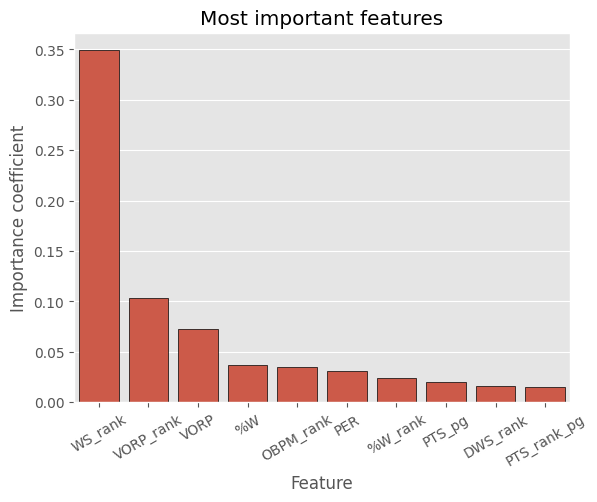

In [29]:
mod.display_feature_importances_xgb(best_model)

In [30]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

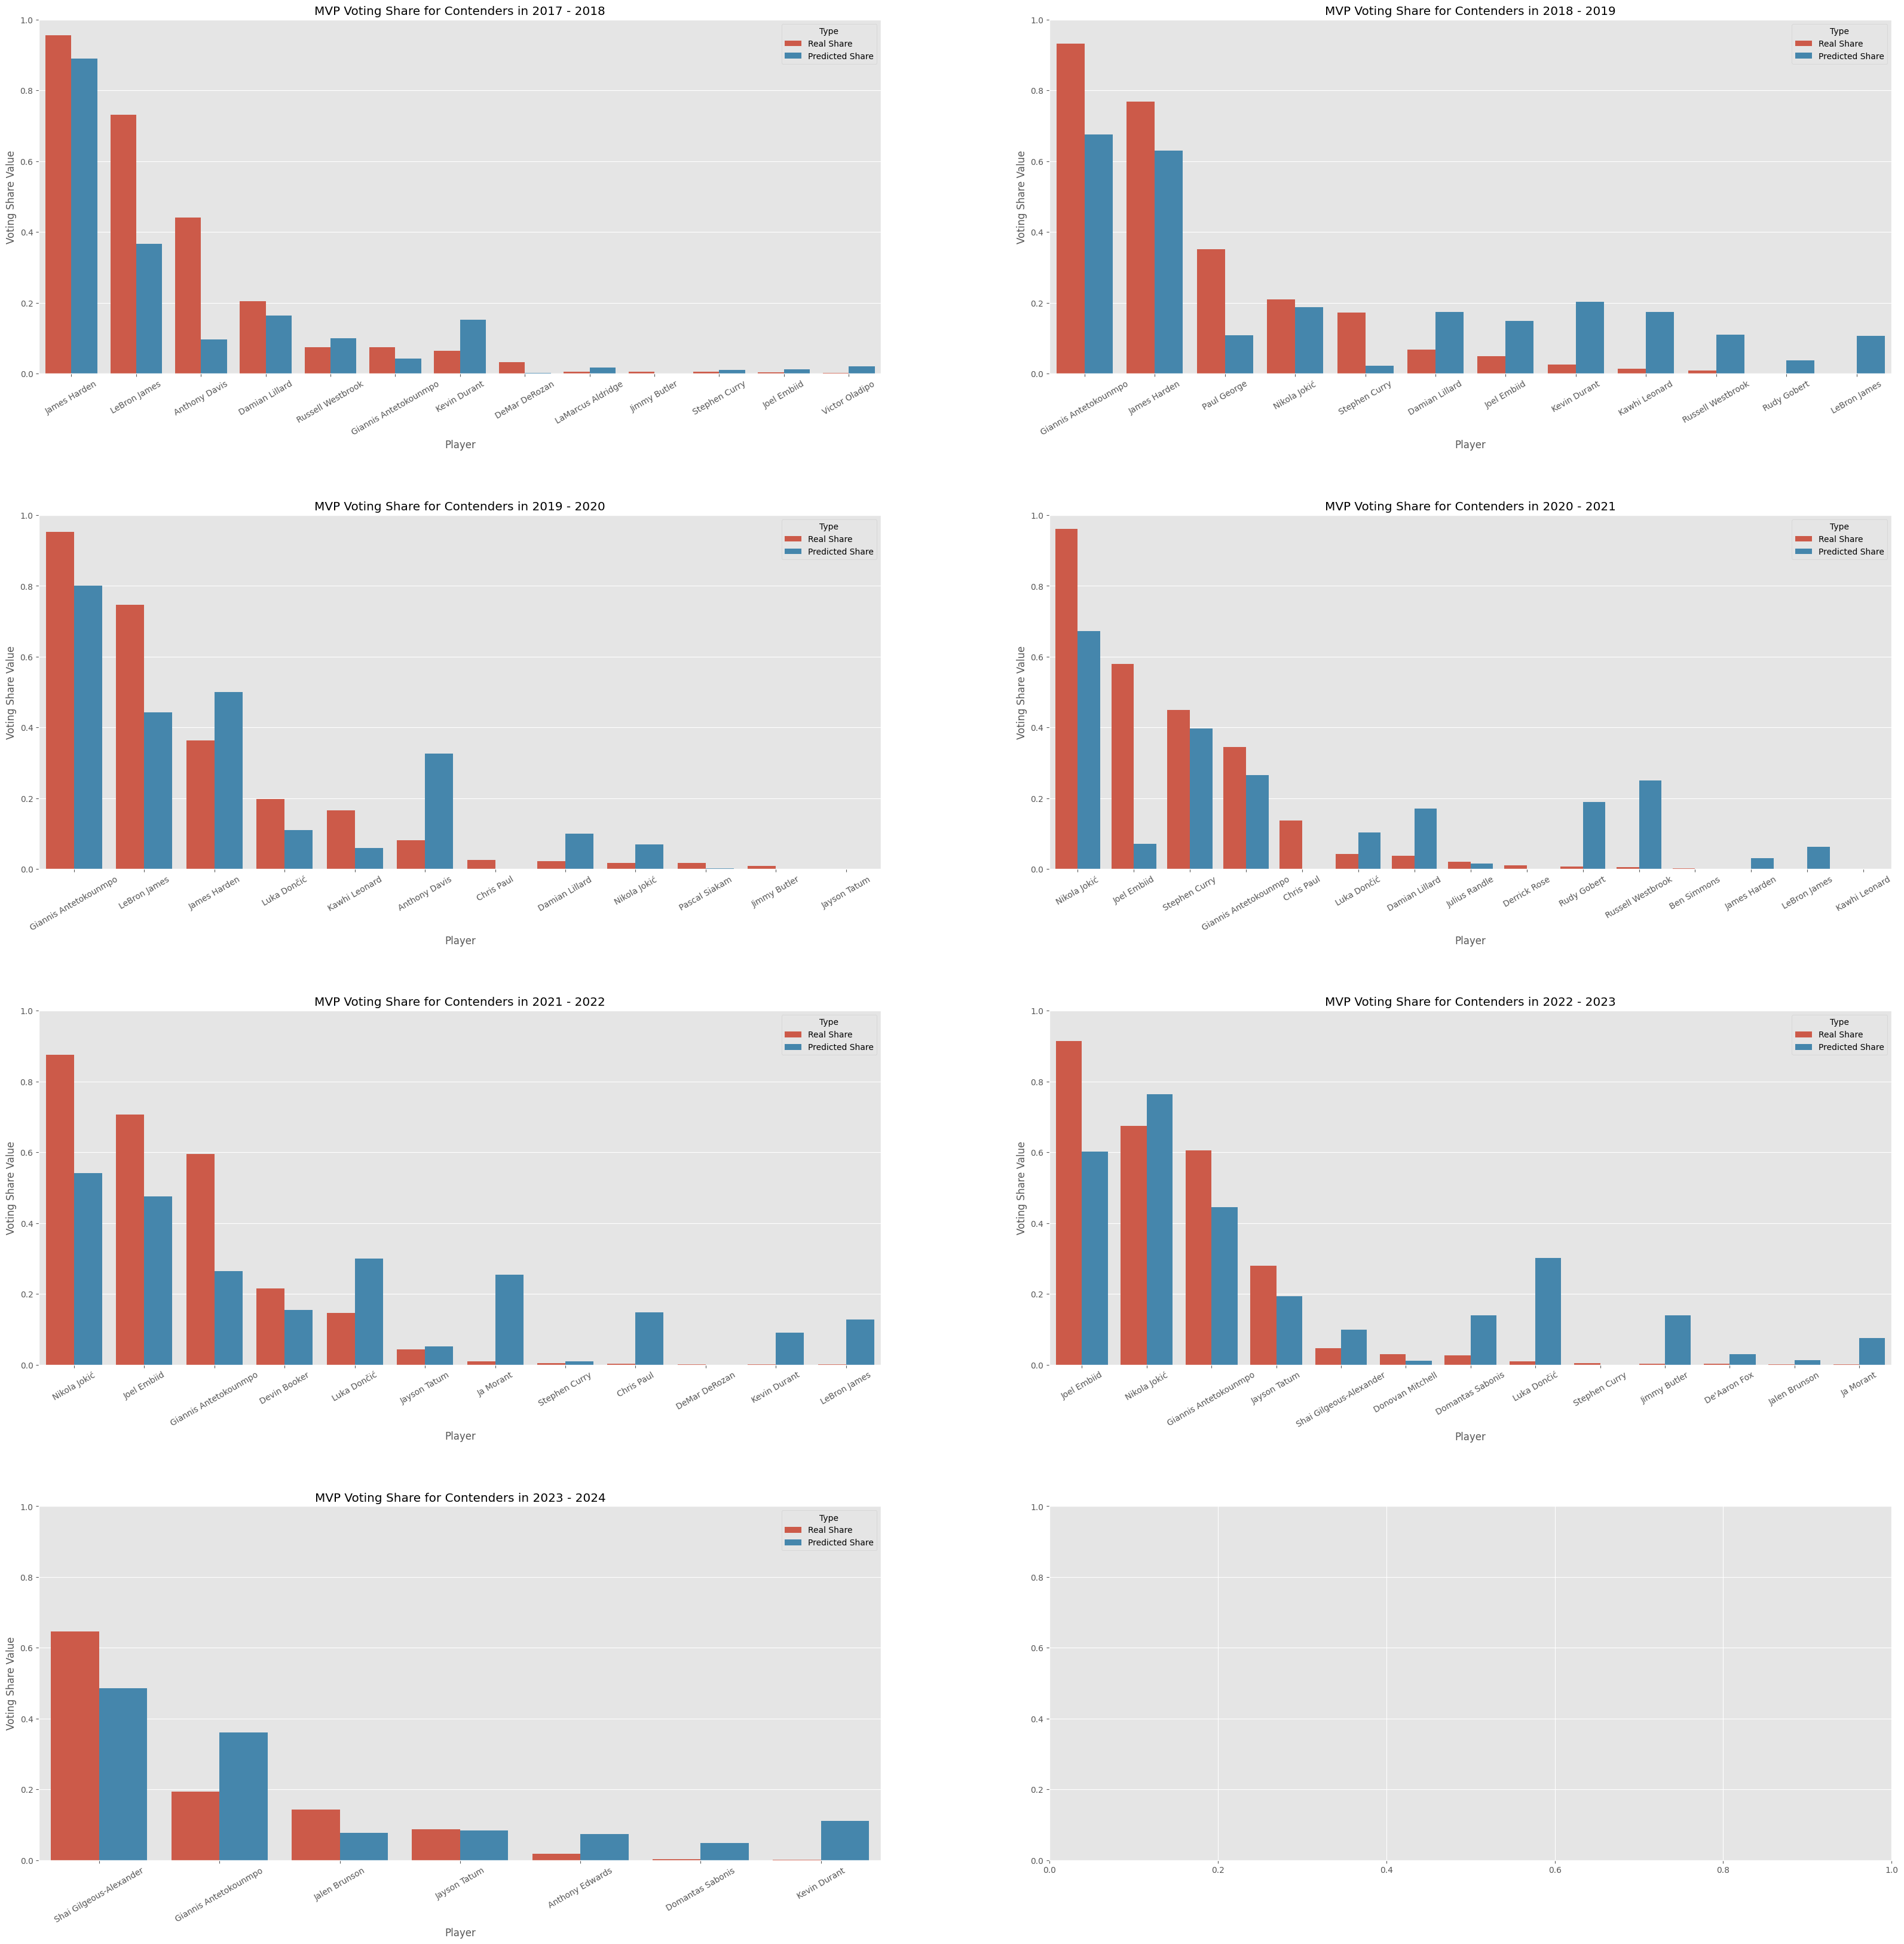

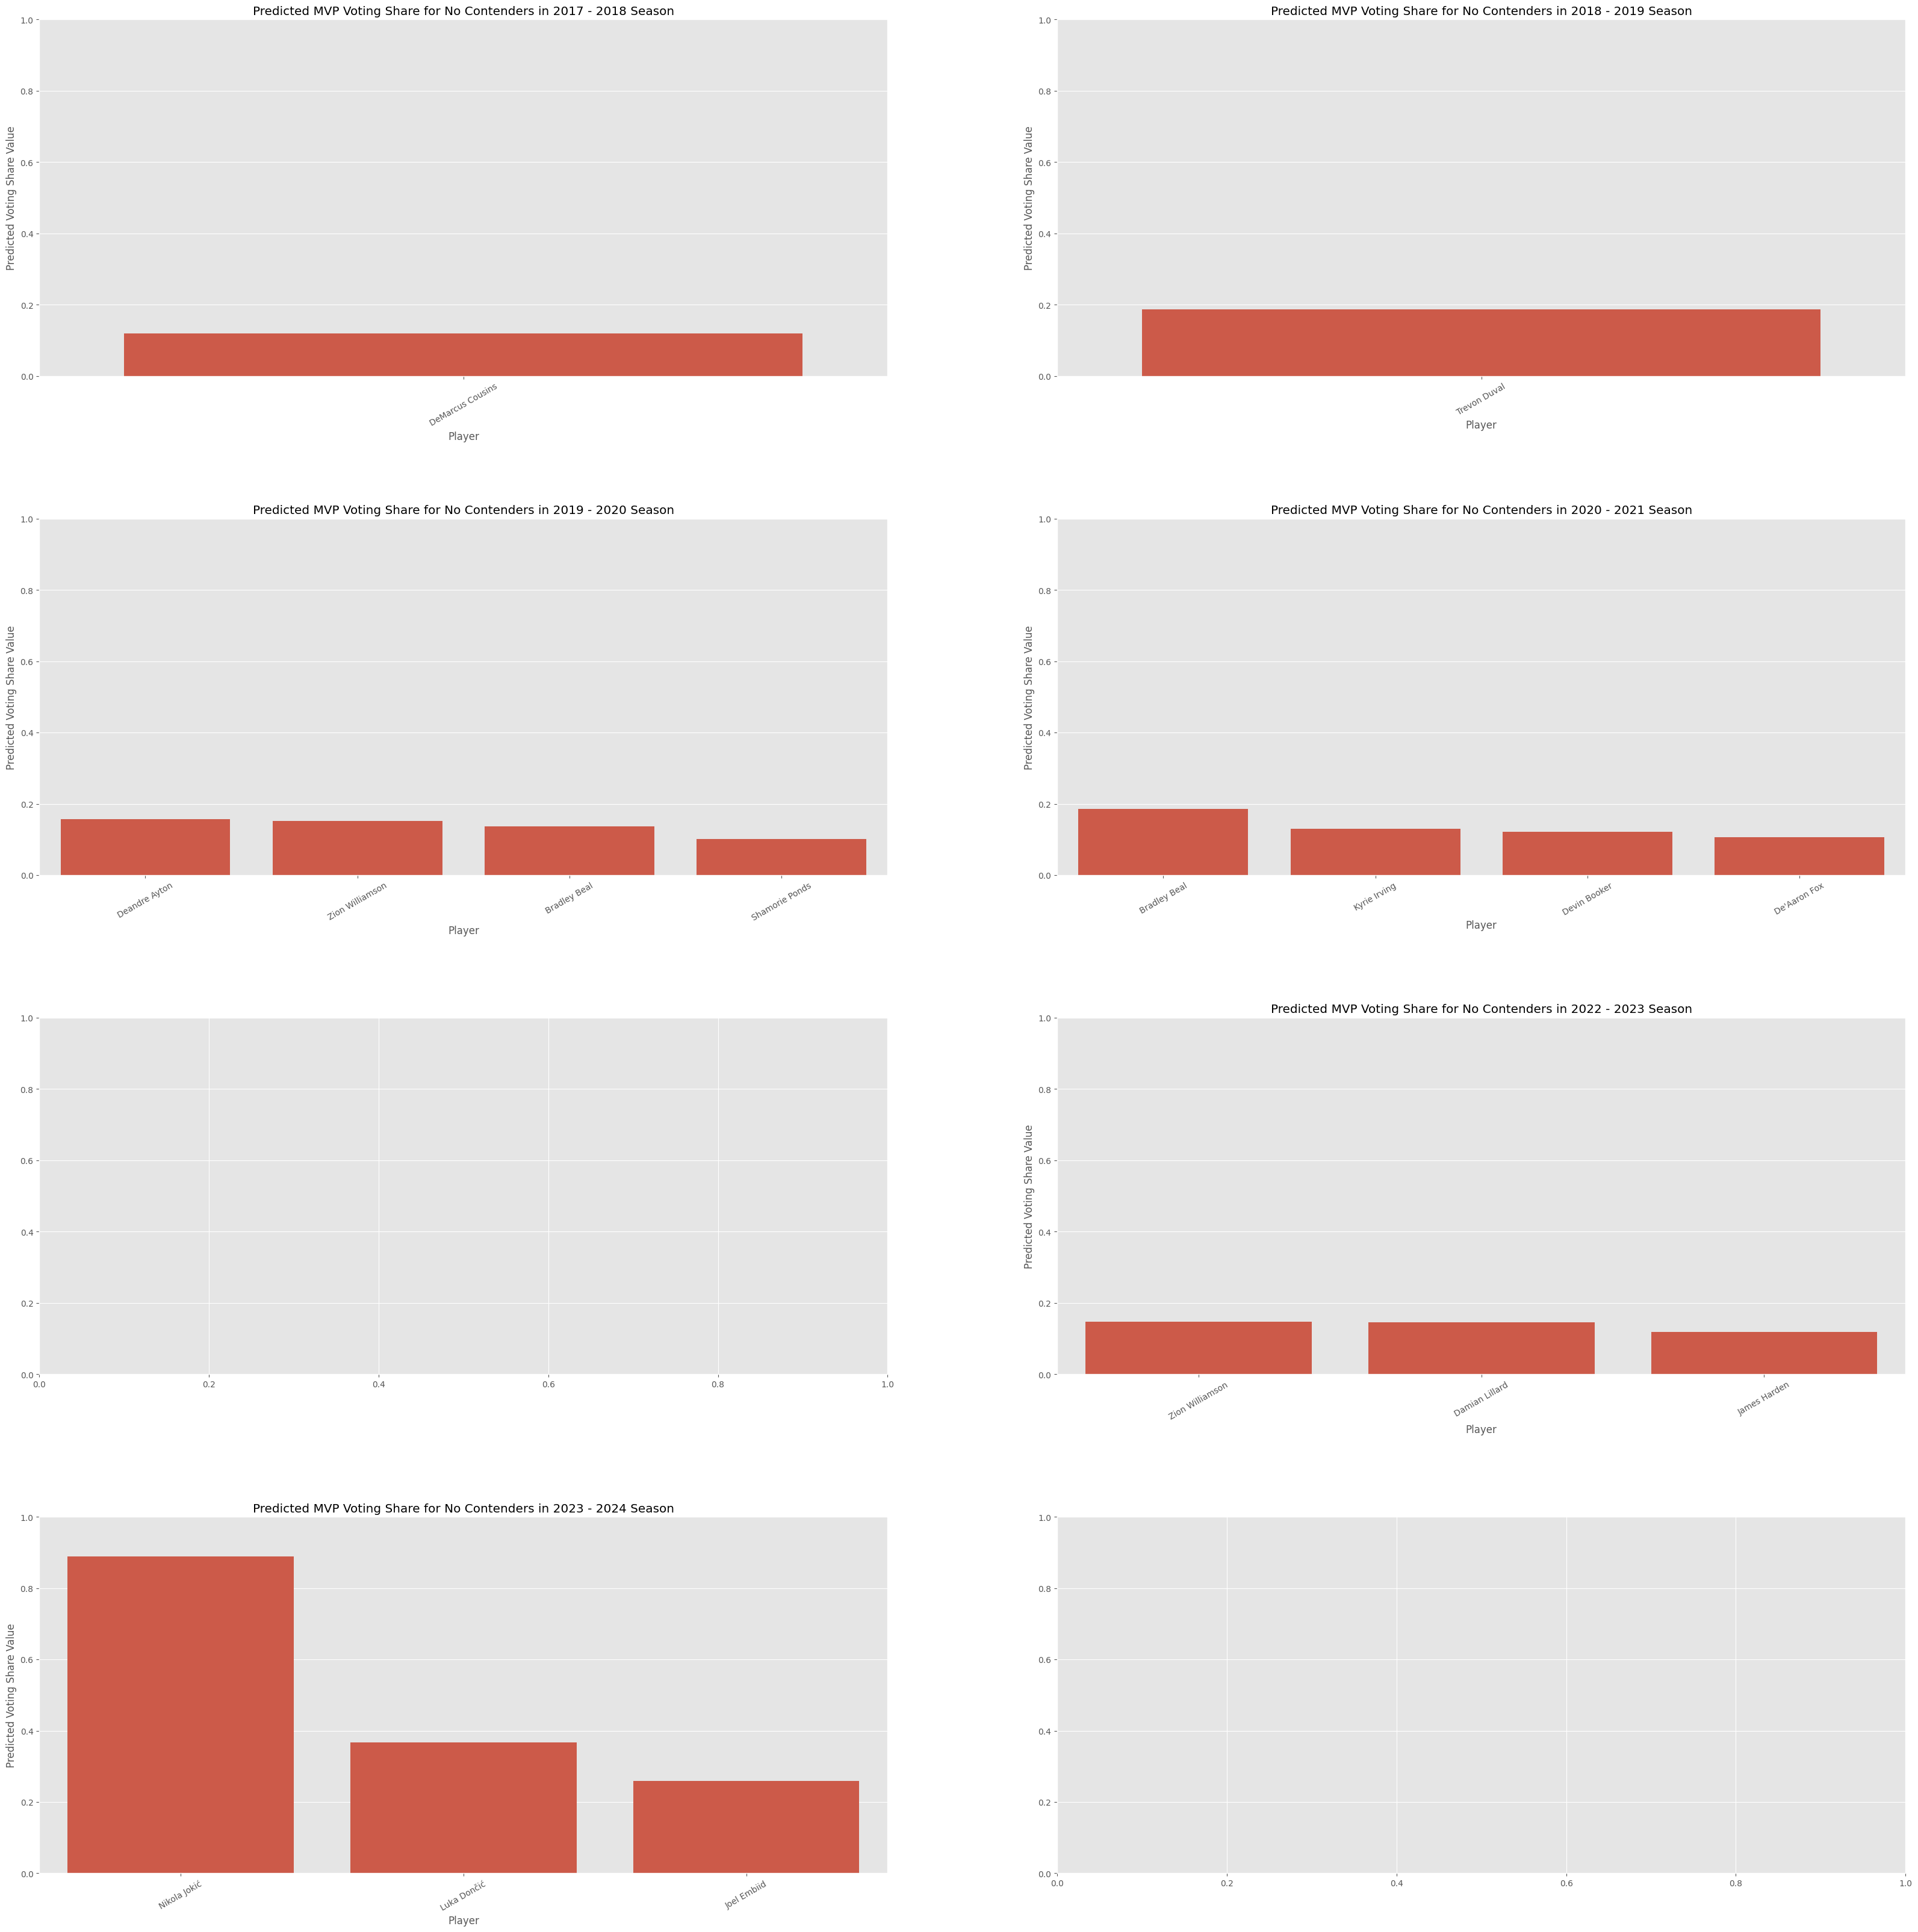

In [31]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])